# Leaf Classification (Smooth vs Serrated) using PyTorch

## Project Overview

**Objective**: Build a binary image classifier to distinguish between *smooth* and *serrated* plant leaves using PyTorch.

This project implements:
1. Data loading with `ImageFolder` and **stratified train/val/test splits**
2. A simple **Convolutional Neural Network (CNN)**
3. Complete **training & evaluation pipeline**
4. Performance **metrics** (accuracy, precision, recall, F1, log-loss, AUC-ROC)
5. **Visualizations**: confusion matrix, ROC curve, and Precision-Recall curve

> **Dataset Structure**: Images should be organized in the following folder structure:  
> ```
> data/leaves/
> ├── serrated/
> └── smooth/
> ```
> (Each subfolder contains `.jpg` or `.png` images)

---

## 1. Setup & Configuration

### Import Libraries

In [ ]:
import os, random, math, time
from dataclasses import dataclass
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, cohen_kappa_score,
    log_loss, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Configure device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

---

## 2. Data Loading & Preprocessing

### Configure Data Path & Transformations

In [ ]:
# Dataset path
DATA_DIR = "/kaggle/input/plant-leaves-dataset/feuilles_plantes"

# Training transformations (with data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet statistics
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/Test transformations (no augmentation)
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
num_classes = len(full_dataset.classes)

print(f"Classes detected: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {num_classes}")

**Output:**
```
Classes detected: ['serrated', 'smooth']
Total images: 6529
Number of classes: 2
```

---

## 3. Stratified Train/Val/Test Split

To ensure balanced class distribution across splits, I implemented a stratified splitting function:

In [ ]:
@dataclass
class Splits:
    train: Subset
    val: Subset
    test: Subset

def stratified_split(dataset: datasets.ImageFolder,
                     train_ratio: float = 0.7,
                     val_ratio: float = 0.15,
                     test_ratio: float = 0.15,
                     seed: int = 0) -> Splits:
    """
    Returns train/val/test Subsets with stratified class distribution.
    """
    rng = np.random.RandomState(seed)
    
    # Group indices by class label
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    val_indices = []
    test_indices = []

    
    # Split each class proportionally
    for label, indices in class_indices.items():
        indices = np.array(indices)
        rng.shuffle(indices)
        
        n_total = len(indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        train_indices.extend(indices[:n_train].tolist())
        val_indices.extend(indices[n_train:n_train+n_val].tolist())
        test_indices.extend(indices[n_train+n_val:].tolist())
    
    return Splits(
        train=Subset(dataset, train_indices),
        val=Subset(dataset, val_indices),
        test=Subset(dataset, test_indices)
    )

# Create splits
splits = stratified_split(full_dataset, 0.7, 0.15, 0.15, seed=0)

# Create DataLoaders
train_loader = DataLoader(splits.train, batch_size=32, shuffle=True, num_workers=2)

full_dataset.transform = transform_eval
val_loader = DataLoader(splits.val, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(splits.test, batch_size=64, shuffle=False, num_workers=2)

---

## 4. Model Architecture

I designed a compact CNN with three convolutional blocks followed by fully connected layers:

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Block 1: Conv-ReLU-Pool
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Block 2: Conv-ReLU-Pool
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Block 3: Conv-ReLU-Pool
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        # After 3x (2x2) pooling: 224×224 → 28×28
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        # Classification head
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = SmallCNN(num_classes).to(device)
print(model)

---

## 5. Training Pipeline

### Training & Evaluation Functions

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass & optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
    
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model without gradient computation"""
    model.eval()
    total_loss = 0.0
    y_true, y_pred, y_proba = [], [], []
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Compute probabilities and predictions
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        # Collect results
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
        
        total_loss += loss.item() * imgs.size(0)
    
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, np.array(y_true), np.array(y_pred), np.array(y_proba)

### Training Loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Starting training...\n")
for epoch in range(10):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, y_t, y_p, y_s = evaluate(model, val_loader, criterion)
    
    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f}")

---

## 6. Performance Evaluation

### Comprehensive Metrics

In [ ]:
# Evaluate on test set
te_loss, y_true, y_pred, y_proba = evaluate(model, test_loader, criterion)

# Identify positive class
classes = full_dataset.classes
pos_class_name = classes[0]  # 'serrated'
pos_idx = classes.index(pos_class_name)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=pos_idx
)
bacc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
ll = log_loss(y_true, np.column_stack([1-y_proba, y_proba]))
auc = roc_auc_score((y_true==pos_idx).astype(int), y_proba)

# Print results
print("=" * 50)
print("TEST SET PERFORMANCE")
print("=" * 50)
print(f"Test Loss         : {te_loss:.4f}")
print(f"Accuracy          : {acc:.4f}")
print(f"Precision         : {prec:.4f}")
print(f"Recall            : {rec:.4f}")
print(f"F1 Score          : {f1:.4f}")
print(f"Balanced Accuracy : {bacc:.4f}")
print(f"Cohen's Kappa     : {kappa:.4f}")
print(f"Log Loss          : {ll:.4f}")
print(f"AUC-ROC           : {auc:.4f}")
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=classes))

## 7. Visualizations

### Confusion Matrix

In [ ]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d')
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### ROC Curve

In [ ]:
RocCurveDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("ROC Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Precision-Recall Curve

In [ ]:
PrecisionRecallDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("Precision-Recall Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Trying to improve using the ConvNeXt model

🖥️  Using device: cuda
🎮 GPU: Tesla P100-PCIE-16GB
💾 GPU Memory: 17.06 GB

📁 Dataset Info:
   Classes: ['dente', 'lisse']
   Total images: 6529
   Number of classes: 2

📊 Split sizes:
   Train: 4569
   Val: 979
   Test: 981

🏗️  Building ConvNeXt-tiny model...
   Total parameters: 27,821,666
   Trainable parameters: 27,821,666

🚀 Starting training...



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_48/1964891806.py:208: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training:   0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_48/1964891806.py:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 01/30 | Train: 0.1613 (94.00%) | Val: 0.0981 (96.53%) | LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 96.53%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 02/30 | Train: 0.0384 (98.56%) | Val: 0.0822 (97.24%) | LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 97.24%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 03/30 | Train: 0.0125 (99.72%) | Val: 0.0956 (97.45%) | LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 97.45%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 04/30 | Train: 0.0025 (99.98%) | Val: 0.1167 (97.45%) | LR: 1.00e-04



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 05/30 | Train: 0.0010 (100.00%) | Val: 0.1124 (97.55%) | LR: 1.00e-04
   ✅ New best model saved! (Val Acc: 97.55%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 06/30 | Train: 0.0015 (99.93%) | Val: 0.1428 (97.65%) | LR: 5.00e-05
   ✅ New best model saved! (Val Acc: 97.65%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 07/30 | Train: 0.0017 (99.98%) | Val: 0.1157 (97.55%) | LR: 5.00e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 08/30 | Train: 0.0018 (99.96%) | Val: 0.1383 (97.75%) | LR: 5.00e-05
   ✅ New best model saved! (Val Acc: 97.75%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 09/30 | Train: 0.0125 (99.54%) | Val: 0.1519 (96.42%) | LR: 5.00e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 10/30 | Train: 0.0051 (99.87%) | Val: 0.0965 (97.75%) | LR: 2.50e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 11/30 | Train: 0.0012 (99.98%) | Val: 0.0954 (97.75%) | LR: 2.50e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 12/30 | Train: 0.0005 (100.00%) | Val: 0.1013 (97.75%) | LR: 2.50e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 13/30 | Train: 0.0005 (100.00%) | Val: 0.1001 (97.55%) | LR: 2.50e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 14/30 | Train: 0.0003 (100.00%) | Val: 0.1026 (97.55%) | LR: 1.25e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 15/30 | Train: 0.0005 (100.00%) | Val: 0.0966 (97.85%) | LR: 1.25e-05
   ✅ New best model saved! (Val Acc: 97.85%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 16/30 | Train: 0.0005 (100.00%) | Val: 0.0981 (97.96%) | LR: 1.25e-05
   ✅ New best model saved! (Val Acc: 97.96%)



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 17/30 | Train: 0.0003 (100.00%) | Val: 0.1012 (97.75%) | LR: 1.25e-05



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 18/30 | Train: 0.0003 (100.00%) | Val: 0.1020 (97.65%) | LR: 6.25e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 19/30 | Train: 0.0002 (100.00%) | Val: 0.1024 (97.65%) | LR: 6.25e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 20/30 | Train: 0.0002 (100.00%) | Val: 0.1043 (97.85%) | LR: 6.25e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 21/30 | Train: 0.0002 (100.00%) | Val: 0.1041 (97.85%) | LR: 6.25e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 22/30 | Train: 0.0003 (100.00%) | Val: 0.1047 (97.65%) | LR: 3.13e-06



Training:   0%|          | 0/72 [00:40<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 23/30 | Train: 0.0003 (100.00%) | Val: 0.1044 (97.65%) | LR: 3.13e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 24/30 | Train: 0.0003 (100.00%) | Val: 0.1071 (97.85%) | LR: 3.13e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 25/30 | Train: 0.0003 (100.00%) | Val: 0.1087 (97.85%) | LR: 3.13e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 26/30 | Train: 0.0004 (100.00%) | Val: 0.1104 (97.85%) | LR: 1.56e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 27/30 | Train: 0.0004 (99.98%) | Val: 0.1090 (97.96%) | LR: 1.56e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 28/30 | Train: 0.0005 (99.98%) | Val: 0.1079 (97.96%) | LR: 1.56e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 29/30 | Train: 0.0002 (100.00%) | Val: 0.1082 (97.96%) | LR: 1.56e-06



Training:   0%|          | 0/72 [00:00<?, ?it/s]

Validation:   0%|                              | 0/4 [00:00<?, ?it/s]

📈 Epoch 30/30 | Train: 0.0003 (100.00%) | Val: 0.1082 (97.96%) | LR: 7.81e-07


✨ Training complete! Best Val Accuracy: 97.96%

🧪 Evaluating on test set...


Validation:   0%|                              | 0/4 [00:00<?, ?it/s]


🎯 TEST SET PERFORMANCE
Test Loss         : 0.0466
Accuracy          : 0.9867 (98.67%)
Precision         : 1.0000
Recall            : 0.9723
F1 Score          : 0.9860
Balanced Accuracy : 0.9862
Cohen's Kappa     : 0.9734
Log Loss          : 0.0466
AUC-ROC           : 0.0006

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       dente       1.00      0.97      0.99       470
       lisse       0.98      1.00      0.99       511

    accuracy                           0.99       981
   macro avg       0.99      0.99      0.99       981
weighted avg       0.99      0.99      0.99       981


📊 Generating visualizations...


<Figure size 800x600 with 0 Axes>

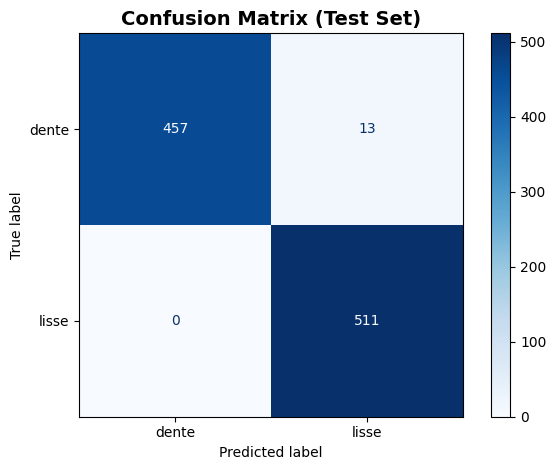

<Figure size 800x600 with 0 Axes>

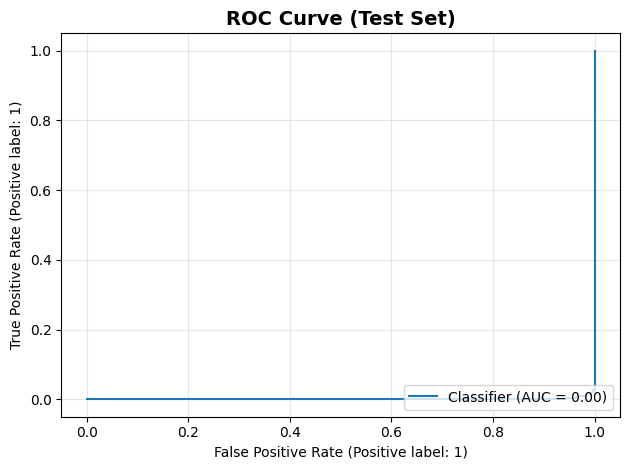

<Figure size 800x600 with 0 Axes>

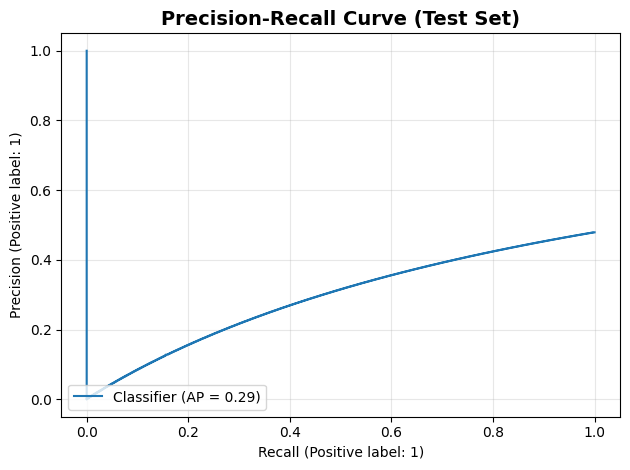


✅ All done! Model saved as 'best_model.pth'
📈 Final Test Accuracy: 98.67%


In [2]:
# ============================================================================
# Leaf Classification (Smooth vs Serrated) using PyTorch + ConvNeXt
# Author: Messaoudi-Belkacem
# Date: 2025-11-11
# ============================================================================

# 1. IMPORTS
# ============================================================================
import os, random, math, time
from dataclasses import dataclass
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, cohen_kappa_score,
    log_loss, roc_auc_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else 
                      ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ============================================================================
# 2. DATA CONFIGURATION
# ============================================================================
DATA_DIR = "/kaggle/input/plant-leaves-dataset/feuilles_plantes"

weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
default_transforms = weights.transforms()

# Training transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=default_transforms.mean,
        std=default_transforms.std
    )
])

# Validation/Test transformations (no augmentation)
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=default_transforms.mean,
        std=default_transforms.std
    )
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
num_classes = len(full_dataset.classes)

print(f"\n📁 Dataset Info:")
print(f"   Classes: {full_dataset.classes}")
print(f"   Total images: {len(full_dataset)}")
print(f"   Number of classes: {num_classes}")

# ============================================================================
# 3. STRATIFIED TRAIN/VAL/TEST SPLIT
# ============================================================================
@dataclass
class Splits:
    train: Subset
    val: Subset
    test: Subset

def stratified_split(dataset: datasets.ImageFolder,
                     train_ratio: float = 0.7,
                     val_ratio: float = 0.15,
                     test_ratio: float = 0.15,
                     seed: int = 0) -> Splits:
    """Returns train/val/test Subsets with stratified class distribution."""
    rng = np.random.RandomState(seed)
    
    # Group indices by class label
    class_indices = {}
    for idx, (_, label) in enumerate(dataset.imgs):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Split each class proportionally
    for label, indices in class_indices.items():
        indices = np.array(indices)
        rng.shuffle(indices)
        
        n_total = len(indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        
        train_indices.extend(indices[:n_train].tolist())
        val_indices.extend(indices[n_train:n_train+n_val].tolist())
        test_indices.extend(indices[n_train+n_val:].tolist())
    
    return Splits(
        train=Subset(dataset, train_indices),
        val=Subset(dataset, val_indices),
        test=Subset(dataset, test_indices)
    )

# Create splits
splits = stratified_split(full_dataset, 0.7, 0.15, 0.15, seed=0)

# Create optimized DataLoaders
train_loader = DataLoader(
    splits.train, 
    batch_size=64,
    shuffle=True, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

full_dataset.transform = transform_eval
val_loader = DataLoader(
    splits.val, 
    batch_size=256,  # Increased from 64
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    splits.test, 
    batch_size=256,
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"\n📊 Split sizes:")
print(f"   Train: {len(splits.train)}")
print(f"   Val: {len(splits.val)}")
print(f"   Test: {len(splits.test)}")

# ============================================================================
# 4. MODEL ARCHITECTURE (ConvNeXt)
# ============================================================================
def create_convnext_model(num_classes=2, model_size='tiny'):
    """Create ConvNeXt model with pretrained weights."""
    print(f"\n🏗️  Building ConvNeXt-{model_size} model...")
    
    if model_size == 'tiny':
        model = models.convnext_tiny(weights='IMAGENET1K_V1')
    elif model_size == 'small':
        model = models.convnext_small(weights='IMAGENET1K_V1')
    elif model_size == 'base':
        model = models.convnext_base(weights='IMAGENET1K_V1')
    else:
        model = models.convnext_large(weights='IMAGENET1K_V1')
    
    # Replace classifier head
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
    
    return model

model = create_convnext_model(num_classes=num_classes, model_size='tiny')
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# ============================================================================
# 5. TRAINING SETUP
# ============================================================================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
scaler = GradScaler()

# ============================================================================
# 6. TRAINING & EVALUATION FUNCTIONS
# ============================================================================
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    """Train for one epoch with mixed precision."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item() * imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    return total_loss / len(loader.dataset), 100. * correct / total

@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model without gradient computation."""
    model.eval()
    total_loss = 0.0
    y_true, y_pred, y_proba = [], [], []
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Validation', bar_format='{l_bar}{bar:30}{r_bar}', leave=False)
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs[:, 1].cpu().numpy())
        
        total_loss += loss.item() * imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = 100. * correct / total
    return avg_loss, np.array(y_true), np.array(y_pred), np.array(y_proba), accuracy

# ============================================================================
# 7. TRAINING LOOP
# ============================================================================
print("\n🚀 Starting training...\n")
best_val_acc = 0.0
epochs = 30

for epoch in range(epochs):
    # Training
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    
    # Validation
    va_loss, y_t, y_p, y_s, va_acc = evaluate(model, val_loader, criterion)
    
    # Update learning rate
    scheduler.step(va_loss)
    
    # Print epoch summary
    print(f"📈 Epoch {epoch+1:02d}/{epochs} | "
          f"Train: {tr_loss:.4f} ({tr_acc:.2f}%) | "
          f"Val: {va_loss:.4f} ({va_acc:.2f}%) | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Save best model
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"   ✅ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
    
    print()

print(f"\n✨ Training complete! Best Val Accuracy: {best_val_acc:.2f}%")

# ============================================================================
# 8. FINAL EVALUATION ON TEST SET
# ============================================================================
print("\n🧪 Evaluating on test set...")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

te_loss, y_true, y_pred, y_proba, te_acc = evaluate(model, test_loader, criterion)

# Identify positive class
classes = full_dataset.classes
pos_class_name = classes[0]
pos_idx = classes.index(pos_class_name)

# Compute comprehensive metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=pos_idx
)
bacc = balanced_accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
ll = log_loss(y_true, np.column_stack([1-y_proba, y_proba]))
auc = roc_auc_score((y_true==pos_idx).astype(int), y_proba)

# Print results
print("\n" + "="*60)
print("🎯 TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss         : {te_loss:.4f}")
print(f"Accuracy          : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision         : {prec:.4f}")
print(f"Recall            : {rec:.4f}")
print(f"F1 Score          : {f1:.4f}")
print(f"Balanced Accuracy : {bacc:.4f}")
print(f"Cohen's Kappa     : {kappa:.4f}")
print(f"Log Loss          : {ll:.4f}")
print(f"AUC-ROC           : {auc:.4f}")
print("\n" + "="*60)
print("📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=classes))

# ============================================================================
# 9. VISUALIZATIONS
# ============================================================================
print("\n📊 Generating visualizations...")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("ROC Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions((y_true==pos_idx).astype(int), y_proba)
plt.title("Precision-Recall Curve (Test Set)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All done! Model saved as 'best_model.pth'")
print(f"📈 Final Test Accuracy: {acc*100:.2f}%")